# Detection de chiffres


Nous l'avons vu, la génération d'images est complémentaire à la classification : les structures fondamentales sont les mêmes, seul le "sens" du flot de données change. 

Ce notebook est une exploration de ce second aspect, et n'est pas fondamental au projet.



### Mise en place 

In [1]:
import torch
from torch import nn, optim
from torch.functional import F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

Téléchargement des données d'entrainement si nécessaire.

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(".",download=True,train=True, transform=ToTensor())
test_data  = datasets.MNIST(".",download=True,train=False, transform=ToTensor())

Sélection CPU/GPU et déclaration des loaders appropriés

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs, labels = map(list, zip(*train_data))
inputs = torch.stack(inputs).to(device)
labels = torch.tensor(labels, dtype=torch.uint8).to(device)

train = TensorDataset(inputs, labels)


inputs, labels = map(list, zip(*test_data))
inputs = torch.stack(inputs).to(device)
labels = torch.tensor(labels, dtype=torch.uint8).to(device)

test = TensorDataset(inputs, labels)

## Modèle

In [4]:

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, 10)          
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Infrastructure

In [5]:
def score(model, dataset):
    model.eval()
    with torch.no_grad(): output = model(dataset.tensors[0])
    success = output.argmax(dim=1) == dataset.tensors[1]
    return success.float().mean().item()

In [6]:

def trainer(dataset, model, optimizer, compute_loss, epochs=10, start_epoch=0, batch_size=1, rate=1e-4, status=None):

    for e in range(start_epoch, start_epoch+epochs):
        for input, target in dataset:
            model.train()
            optimizer.zero_grad()

            output = model(input)
            loss = compute_loss(output, target)
            loss.backward()
            optimizer.step()

            if status and status.should_update(e):
                status.update(e, model)

## Entrainement

In [7]:
model = Model().to(device)

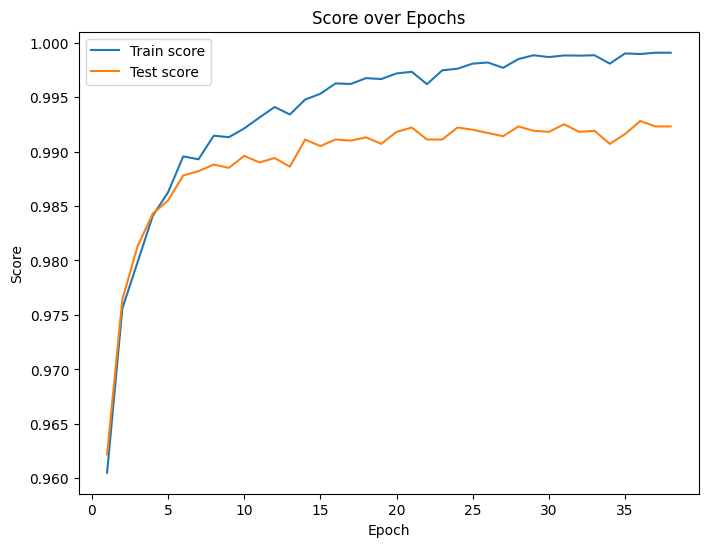

KeyboardInterrupt: 

In [ ]:

optimizer = optim.Adam(model.parameters(), lr=1e-3)
compute_loss = nn.BCEWithLogitsLoss()

dataset = DataLoader(train, batch_size=64, shuffle=True)
trainer(dataset, model, optimizer,  compute_loss, epochs=1000)


In [14]:
print("train", score(model, train))
print("test", score(model, test))

train 0.9993333220481873
test 0.9921999573707581
